# 1. MNIST Dataset

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

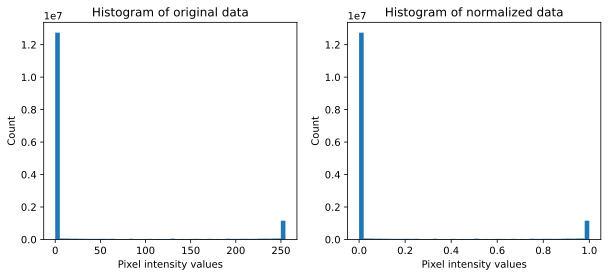

In [3]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

### 1.1 Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

### 1.2 Create the DL Model

In [5]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

  # test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3009, grad_fn=<NllLossBackward0>)


### 1.3 Create a function on training model

In [6]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


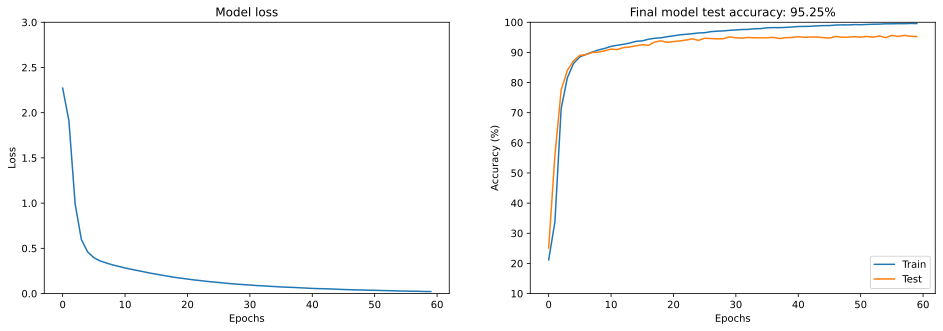

In [7]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# 2. Weights Comparison

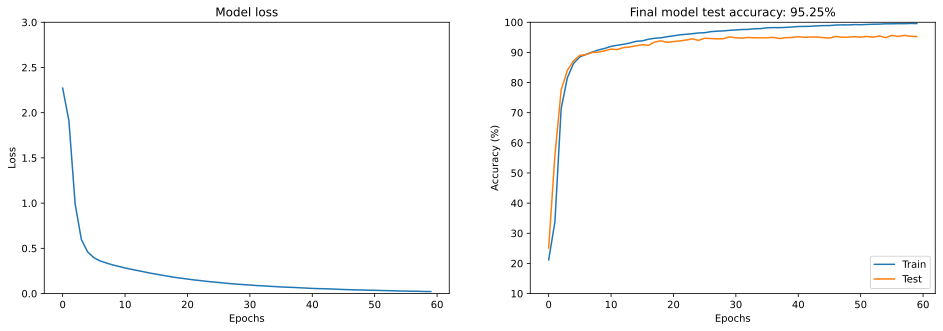

In [8]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

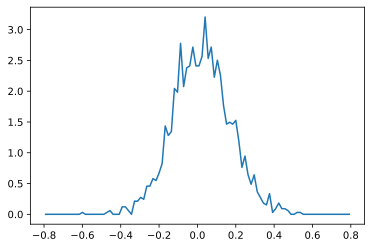

In [10]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W, net.fc1.weight.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy




# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [12]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx = np.zeros((numepochs,100))
  histy = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)
  
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy


In [14]:
trainAcc,testAcc,losses,net,histx,histy = funtion2trainTheModel()


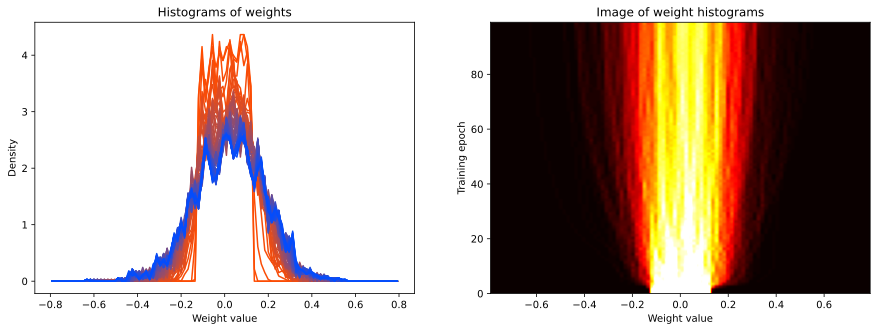

In [15]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='top',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()

# 3. Scrambled

### 3.1 Scrambled the Image

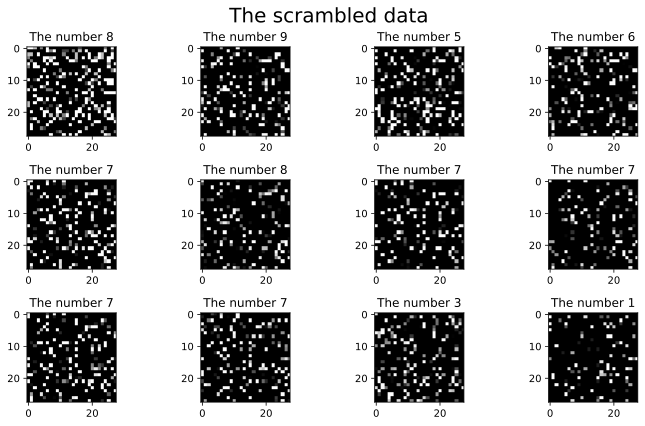

In [16]:
# randomly scramble the data,
# preserving the re-ordering for each image
eggs = np.random.permutation(data.shape[1])
scrambled = dataNorm[:,eggs]


# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(scrambled[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('The scrambled data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

### 3.2 Apply on the Model

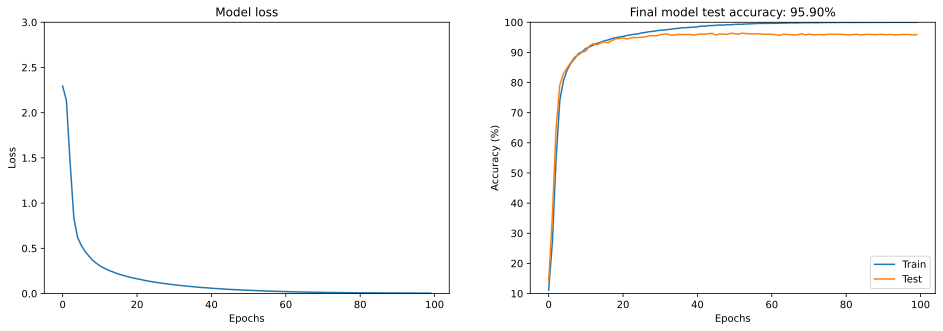

In [17]:
# Step 1: convert to tensor
dataT   = torch.tensor( scrambled ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NOTE: no log-softmax above because of the loss function below
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer


# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

trainAcc,testAcc,losses,net = funtion2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# 4. Shifted

In [ ]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)


# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

# now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = test_loader.dataset.tensors[0][i,:]
  
  # reshape and roll by max. 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img.reshape(28,28) ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)


# Note: now run the previous cell again to confirm the shifting

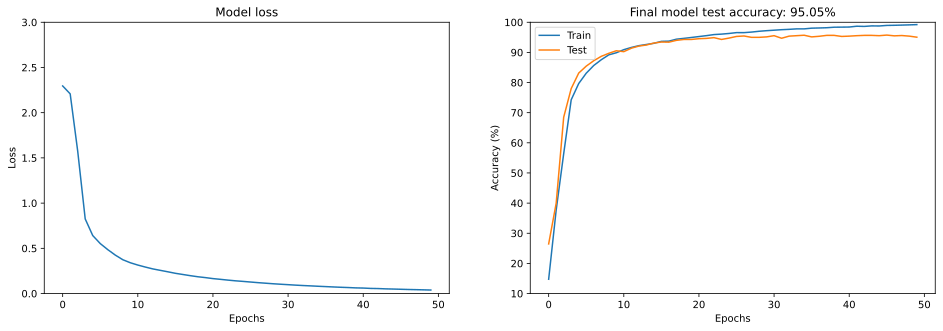

In [18]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer


  # a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


trainAcc,testAcc,losses,net = funtion2trainTheModel()


fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()